# Classification in SKTime


## Import


In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [75]:
try:
    import sktime
except:
    !pip install sktime --user
    !pip install tsfresh 
    !pip install numba
    !pip install llvmlite
import sktime

In [76]:
from sktime.transformations.panel.rocket import MiniRocket

In [77]:
from sktime.datasets import load_from_tsfile
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

## Database

We will take database of Time Series from [open-power-system-data](https://open-power-system-data.org/). From all of them we will use only one as example

In [78]:
url = 'https://data.open-power-system-data.org/time_series/2020-10-06/'
datafile = url + 'time_series_60min_singleindex.csv'
df_all = pd.read_csv(datafile, index_col='utc_timestamp', parse_dates=True, low_memory=False)

We will select Germany, all consumption

In [79]:
def extract_country(df_all, country_code, year_min=None, year_max=None):
    """Extract data for a single country"""
    
    # List of columns to extract
    columns = [col for col in df_all.columns if col.startswith(country_code)]
    
    # Extract columns and remove country codes from column labels
    columns_map = {col : col[3:] for col in columns}
    df_out = df_all[columns].rename(columns=columns_map)
    
    # Exclude years outside of specified range, if any
    if year_min is not None:
        df_out = df_out[df_out.index.year >= year_min]
    if year_max is not None:
        df_out = df_out[df_out.index.year <= year_max]
        
    return df_out

def transform_dataframe(df, cols_map):
    # Rename columns for convenience
    df = df[list(cols_map.keys())].rename(columns=cols_map)
    # Convert from MW to GW
    df = df / 1000
#     df = df.groupby(df.index.hour).mean()
    df = df.rename_axis('Date')
#     df.index = df.index.strftime('%Y-%m-%d-%h')
    return df

In [80]:
df_hrly = extract_country(df_all, country_code='DE', year_min=2015, year_max=2019)
df_hrly.sample(3)

cols_map = {'load_actual_entsoe_transparency' : 'Consumption',
            'wind_generation_actual' : 'Wind',
            'solar_generation_actual' : 'Solar'}
df = transform_dataframe(df_hrly, cols_map).dropna()

# df wind + solar generation
df['Wind+Solar'] = df[['Wind', 'Solar']].sum(axis=1, skipna=False)
df.to_csv('de_clf_data.csv')
df.head()

Consumption    Wind  Solar  Wind+Solar
Date                                                             
2015-01-01 07:00:00+00:00       41.133  10.208  0.071      10.279
2015-01-01 08:00:00+00:00       42.963  10.029  0.773      10.802
2015-01-01 09:00:00+00:00       45.088  10.550  2.117      12.667
2015-01-01 10:00:00+00:00       47.013  11.390  3.364      14.754
2015-01-01 11:00:00+00:00       48.159  12.103  4.198      16.301

We make a dataset with classes. To do this, it is proposed to set the task of determining the daily consumption of the season (winter, spring, autumn, summer):
* Divide all data into 4 seasons (winter, spring, autumn, summer)
* take data in increments of 1 hour.
* create segments of 24 hours (1 day).

This task is completely artificial, but generally corresponds to some of the tasks of standard time series classification tests, for example, see [here] (http://www.timeseriesclassification.com/description.php?Dataset=PowerCons).

For classification, data should be divided into segments. 
In our case, the segment length will be 24 points.

For the purpose of creating a dataset, let's create 2 functions, the first `split_by_month` will split our dataset into months. 
The second `to_segments` function will create segments 24 hours a day.

In [81]:
def split_by_month(df, months):
    df_ = pd.DataFrame()
    for month in np.atleast_1d(months):
        df_ = df_.append(df.loc[df.index.month == month])
    return df_

def to_segments(df, column, size = 24):  
    df.index.hour[0]
    start_idx = 24-df.index.hour[0]
    df = df.iloc[start_idx:]
    val = df[[column]].values
    return val[:size*(val.size//size)].reshape(-1,size)

In [82]:
winter = to_segments(split_by_month(df, [1,2, 12]), 'Consumption', size = 24)
summer = to_segments(split_by_month(df, [6, 7, 8]), 'Consumption', size = 24)
autumn = to_segments(split_by_month(df, [9,10,11]), 'Consumption', size = 24)
spring = to_segments(split_by_month(df, [3, 4, 5]), 'Consumption', size = 24)
print(winter.shape, summer.shape, autumn.shape, spring.shape)

(448, 24) (458, 24) (452, 24) (458, 24)



Now we have 4 classes

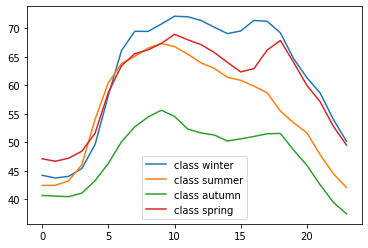

In [83]:
plt.figure()
day = 10
for i,(c,d) in enumerate(zip([winter,summer,autumn,spring],['winter','summer','autumn','spring'])):
    plt.plot(c[day], label="class " + str(d))
plt.legend(loc="best")
plt.show()
plt.close()

Segments seems to be almost similar, but we will try to classify them

In [84]:
X = np.concatenate((
                    winter, 
                    summer, 
                    autumn, 
                    spring))
y = np.concatenate((
                    0*np.ones(winter.shape[0]),
                    1*np.ones(summer.shape[0]),
                    2*np.ones(autumn.shape[0]),
                    3*np.ones(spring.shape[0])
                   ))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1271, 24) (1271,) (545, 24) (545,)


The modern version of `SKTime` allows the format of arrays in the form of `2d ndarray (numpy)` for univariable time series. 

For multivariable time series, the array can be specified as a `3d ndarray`.

In the general case, a one-variable series can also be specified as a multi-variable series with the array dimension $\text{samples} \times \text{variable} \times \text{segment}$.

Also, other formats are provided in the `SKTime` package. including specialized ones. 

To convert between formats, `convert` and `convert_to` from the `sktime.datatypes` module are used. For example, to convert a two-dimensional array to the built-in one-variable format, you can use the following script
```python
     df = convert_to(np.atleast_3d(X).transpose(0,2,1), to_type="nested_univ")
```
However, not all `SKTime` functions support `2d ndarray`, so let's create `nested_univ` copies of the data.

In [85]:
from sktime.datatypes import convert_to
df_train = convert_to(np.atleast_3d(X_train).transpose(0,2,1), to_type="nested_univ") 
df_test  = convert_to(np.atleast_3d(X_test ).transpose(0,2,1), to_type="nested_univ") 

## Classification sklearn

Before testing specialized methods from the `SKTime` package, let's look at the results of the standard approaches from `sklearn`. In time series analysis, among such standard approaches, the `random forest` is the most common. Also let's try the `k-neighbors` algorithm with Euclidean distance as some preliminary baseline estimate.

In [86]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')


 test score 0.881


In [87]:
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}') 

 test score 0.879


## Raw-Data-based classifiers

We discussed that the `1-NN DTW` classifier can be used as some base score. Recall that this approach compares time series "as a whole". Distance `DTW` refers to elastic measures that are resistant to distortions of various segments of the series.

In the `SKTime` package, this type of algorithms is located in the `distance_based` module.

In [88]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
clf = KNeighborsTimeSeriesClassifier(n_neighbors=1, distance="dtw")
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

 test score 0.839


The result obtained did not exceed the result with the Euclidean distance. This is probably due to the similarity of the segment shapes. However, `1-NN DTW` can also be implemented in more advanced forms. One such form is the difference distance `ddtw`.

In [89]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

clf = KNeighborsTimeSeriesClassifier(n_neighbors=1, distance="ddtw")
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

 test score 0.917


Another option for a data-based classifier is the classifier shapelet.
A shapelet is a segment of the time series that has the highest discriminatory ability for the problem. 
In other words, for shapelet regions, the differences between classes are most significant and similarity inside the classes high enougth.

In the `SKTime` shapelets can be found in the `sktime.classification.shapelet_based` module.

In [90]:
from sktime.classification.shapelet_based import ShapeletTransformClassifier

clf = ShapeletTransformClassifier(estimator=RandomForestClassifier(n_estimators=100),
                                  n_shapelet_samples=100,
                                  max_shapelets=100,
                                  batch_size=20)

clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

 test score 0.916


Shapelet-based classifiers allow you to find the most distinct patterns in the data. As discussed in the theoretical part, in some cases it is more useful to repeat such patterns. In such and similar problems, to describe time series (to represent them), approaches based on the so-called dictionary (Dictionary-based or Bag-of-Symbols, BOS) can be applied.

The `SKTime` package uses the `sktime.classification.dictionary_based` module to work with dictionaries.

In [91]:
from sktime.classification.dictionary_based import (ContractableBOSS, 
                                                    IndividualBOSS, 
                                                    IndividualTDE, 
                                                    MUSE, WEASEL)

In [92]:
clf = IndividualBOSS(random_state=47)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.8110091743119267

In [93]:
clf = IndividualTDE(random_state=47)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.8403669724770643

In [94]:
clf = MUSE(random_state=47)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9504587155963303

## Features-Based-Classifiers

The classifiers discussed above could be attributed to the so-called raw-data-based classifiers. A feature-based classifiers can often be preferred. One of the most popular approaches among such classifiers are interval approaches. The essence of these approaches is
* search or random selection of intervals within time series;
* extraction of a certain set of features for such an interval;
* building some classifier, for example, a tree for each interval;
* combining results for all intervals, for example, using a forest of trees.

In the `SKTime` package, such methods can be found in the `sktime.classification.interval_based` module.

In [95]:
from sktime.classification.interval_based import (TimeSeriesForestClassifier, 
                                                  RandomIntervalSpectralEnsemble, 
                                                  SupervisedTimeSeriesForest)

In [96]:
clf = TimeSeriesForestClassifier(n_estimators=100,random_state=47)
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

 test score 0.947


In [97]:
clf = RandomIntervalSpectralEnsemble(n_estimators=100, random_state=47)
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

 test score 0.934


In [98]:
clf = SupervisedTimeSeriesForest(n_estimators=100, random_state=47)
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

 test score 0.947


In addition to tree-based algorithms, methods based on kernel transformations are currently popular. One of the most successful algorithms in this direction is the `Rocket` algorithm. The essence of this algorithm is reduced to data transformation using a set of convolutional kernels with randomly selected parameters. The authors then recommend using `RidgeClassifierCV`, which is a Logistic Regression with `L2` regularization, the regularization parameter being chosen by cross-validation.

We will look at an accelerated version of the `MiniRocket` transformation.

In [99]:
from sklearn.linear_model import RidgeClassifierCV

transform = MiniRocket(num_kernels=10000, n_jobs = -1)
Xt_train = transform.fit_transform(X_train)
Xt_test  = transform.transform(X_test)

clf = RidgeClassifierCV()
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

 test score 0.912


Another important feature-based approach is the feature space selection approach. Such a space can only be the use of a few summary statistics (mean, median, variance, etc.), which should somehow describe the time series.

In some cases, summary statistics may not be enough. 
In the general case, in addition to the summary statistics, there can be
Temporal or frequency (pseudo-frequency) signs. 
Let's list examples of such signs in the form of a list:
* summary statistics: mean, median, variance, entropy, etc.;
* temporal signs: slope, trend nature, points of intersection of some threshold values, peak values and their positions, autocorrelation coefficients, etc.
* frequency features: spectrum peak values, autoregression coefficients, coefficients, for example, wavelet decompositions, etc.
* other signs.
In the general case, feature spaces can be quite large. However, as a rule, not all features are important, so feature selection should be carried out for such spaces.

There are existing a lot of ready-made solutions, where some of the most significant subspaces have already been selected from volumetric spaces. Among such approaches, `Catch22` is popular. In this approach, among the order of `4500` features, `22` are selected, which are of great importance for standard tests.

In the `SKTime` package, the described approaches can be found in the `sktime.classification.feature_based` module. Let's test 2 classifiers from this package `SummaryClassifier`, representing the description of time series by summary statistics and `Catch22Classifier`, representing the description of the time series by the feature space indicated above.

In [100]:
from sktime.classification.feature_based import SummaryClassifier, Catch22Classifier
from sklearn.ensemble import RandomForestClassifier

In [101]:
clf = SummaryClassifier(estimator=RandomForestClassifier(n_estimators=100))
clf.fit(X_train, y_train)
print(f' test score {clf.score(df_test, y_test):.3f}')

 test score 0.631


In [102]:
clf = Catch22Classifier(estimator=RandomForestClassifier(n_estimators=100))
clf.fit(X_train, y_train)
print(f' test score {clf.score(df_test, y_test):.3f}')

 test score 0.839


Additionally, we note that the `SKTime` package also allows you to create pipelines for feature extraction and classification in manual mode. For example, as shown below. The example shown represents the `TimeSeriesForestClassifier` algorithm, however, not completely.

In [103]:
from sktime.transformations.panel.summarize import RandomIntervalFeatureExtractor
from sktime.utils.slope_and_trend import _slope
from sklearn.pipeline import Pipeline

steps = [(
        "extract",  RandomIntervalFeatureExtractor(
            n_intervals="sqrt", features=[np.mean, np.std, _slope]
        )),
    ("clf", RandomForestClassifier()),]

clf = Pipeline(steps)
clf.fit(df_train, y_train)
print(f' test score {clf.score(df_test, y_test):.3f}')

 test score 0.910


It is also important to note the possibility of working with some other libraries for working with features. So, one of the most popular libraries is [`tsfresh`](https://tsfresh.readthedocs.io/en/latest/text/introduction.html). This library is quite popular, although not the most modern. At the moment, `tsfresh` functionality is being integrated into `SKTime`. Therefore, we will show the possibility of working with `tsfresh` as a separate tool.

At its simplest, `tsfresh` requires a DataFrame format in which all data segments are presented in a single column (for single-variable data). To convert formats, we will use the built-in function `sktime` `from_nested_to_long`.

The `extract_features` method is used to extract the `tsfresh` features.

In [104]:
from tsfresh import extract_features
from sklearn.preprocessing import MinMaxScaler
from sktime.datatypes._panel._convert import from_nested_to_long

In [111]:
Xt_train = extract_features(
            from_nested_to_long(df_train),
            column_id="index",
            column_value="value",
            column_kind="column",
            column_sort="time_index", )
Xt_train.head(2)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 10/10 [00:42<00:00,  4.24s/it]


var_0__variance_larger_than_standard_deviation  var_0__has_duplicate_max  \
0                                             1.0                       0.0   
1                                             1.0                       0.0   

   var_0__has_duplicate_min  var_0__has_duplicate  var_0__sum_values  \
0                       0.0                   0.0           1147.970   
1                       0.0                   0.0           1196.845   

   var_0__abs_energy  var_0__mean_abs_change  var_0__mean_change  \
0       55546.291492                1.706478            0.143348   
1       60363.754601                1.768826           -0.150478   

   var_0__mean_second_derivative_central  var_0__median  ...  \
0                              -0.034932        49.0810  ...   
1                              -0.048023        51.6575  ...   

   var_0__permutation_entropy__dimension_6__tau_1  \
0                                        2.798513   
1                                        2.360736   

   var_0__permutation_entropy__dimension_7__tau_1  \
0                                        2.890372   
1                                        2.630253   

   var_0__query_similarity_count__query_None__threshold_0.0  \
0                                                NaN          
1                                                NaN          

   var_0__matrix_profile__feature_"min"__threshold_0.98  \
0                                                NaN      
1                                                NaN      

   var_0__matrix_profile__feature_"max"__threshold_0.98  \
0                                                NaN      
1                                                NaN      

   var_0__matrix_profile__feature_"mean"__threshold_0.98  \
0                                                NaN       
1                                                NaN       

   var_0__matrix_profile__feature_"median"__threshold_0.98  \
0                                                NaN         
1                                                NaN         

   var_0__matrix_profile__feature_"25"__threshold_0.98  \
0                                                NaN     
1                                                NaN     

   var_0__matrix_profile__feature_"75"__threshold_0.98  \
0                                                NaN     
1                                                NaN     

   var_0__mean_n_absolute_max__number_of_maxima_7  
0                                       53.385857  
1                                       55.839714  

[2 rows x 789 columns]

In [112]:
Xt_test = extract_features(
            from_nested_to_long(df_test),
            column_id="index",
            column_value="value",
            column_kind="column",
            column_sort="time_index", )
Xt_test.head(2)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 10/10 [00:23<00:00,  2.38s/it]


var_0__variance_larger_than_standard_deviation  var_0__has_duplicate_max  \
0                                             1.0                       0.0   
1                                             1.0                       0.0   

   var_0__has_duplicate_min  var_0__has_duplicate  var_0__sum_values  \
0                       0.0                   0.0           1477.696   
1                       0.0                   1.0           1034.632   

   var_0__abs_energy  var_0__mean_abs_change  var_0__mean_change  \
0       92362.073364                2.077826            0.024783   
1       45115.251980                1.206522            0.167826   

   var_0__mean_second_derivative_central  var_0__median  ...  \
0                              -0.073591         65.723  ...   
1                               0.053455         45.234  ...   

   var_0__permutation_entropy__dimension_6__tau_1  \
0                                        2.625048   
1                                        2.698011   

   var_0__permutation_entropy__dimension_7__tau_1  \
0                                        2.813355   
1                                        2.890372   

   var_0__query_similarity_count__query_None__threshold_0.0  \
0                                                NaN          
1                                                NaN          

   var_0__matrix_profile__feature_"min"__threshold_0.98  \
0                                                NaN      
1                                                NaN      

   var_0__matrix_profile__feature_"max"__threshold_0.98  \
0                                                NaN      
1                                                NaN      

   var_0__matrix_profile__feature_"mean"__threshold_0.98  \
0                                                NaN       
1                                                NaN       

   var_0__matrix_profile__feature_"median"__threshold_0.98  \
0                                                NaN         
1                                                NaN         

   var_0__matrix_profile__feature_"25"__threshold_0.98  \
0                                                NaN     
1                                                NaN     

   var_0__matrix_profile__feature_"75"__threshold_0.98  \
0                                                NaN     
1                                                NaN     

   var_0__mean_n_absolute_max__number_of_maxima_7  
0                                       68.742857  
1                                       47.743143  

[2 rows x 789 columns]

And so we identified 789 features. Among the signs there are values of quite different orders, as well as missing values.
We will standardize the obtained features.

In [113]:
Xt_train = (Xt_train - Xt_train.min())/(Xt_train.max() - Xt_train.min()).astype(np.float32)
Xt_test  = (Xt_test  - Xt_train.min())/(Xt_train.max() - Xt_train.min()).astype(np.float32)

In [114]:
Xt_train = Xt_train.dropna(axis=1)
Xt_test  = Xt_test[Xt_train.columns]

In [115]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(Xt_train, y_train)
clf.score(Xt_test, y_test)

0.5798165137614679

Note that, if necessary, in the `SKTime` package, you can also find a number of transformations not considered here, feature extraction techniques and time series classification techniques.